In [3]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import pdal


from forest_structure_tools.metrics import forest_structure_metrics

In [4]:
data_dir = Path("../data")
plots_dir = data_dir / "outputs" / "plots"
plots_lidar_dir = plots_dir / "lidar"

def read_plot_lidar(plot_id: str):
    pl = pdal.Reader(str(plots_lidar_dir / f"{plot_id}.copc.laz")).pipeline()
    pl.execute()

    return pl.arrays[0]

In [5]:
plots_gdf = gpd.read_file(plots_dir / "plots.geojson")
plot_ids = plots_gdf['id'].to_list()

In [6]:
metrics_dir = plots_dir / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

no_grid_dir = metrics_dir / "no_grid_z_1m"
no_grid_dir.mkdir(parents=True, exist_ok=True)

grid_10m_dir = metrics_dir / "grid_10m_z_1m"
grid_10m_dir.mkdir(parents=True, exist_ok=True)

grid_5m_dir = metrics_dir / "grid_5m_z_1m"
grid_5m_dir.mkdir(parents=True, exist_ok=True)


grid_1m_dir = metrics_dir / "grid_1m_z_1m"
grid_1m_dir.mkdir(parents=True, exist_ok=True)

In [7]:
def calculate_metrics(plot_id: id):
    points = read_plot_lidar(plot_id)
    x = points['X']
    y = points['Y']
    z = points['Z']

    fr_mask = points['ReturnNumber'] == 1
    rn_weights = 1 / points['NumberOfReturns']
    i_weights = points['Intensity']


    v0_mask = z > 0
    v05_mask = z > 0.5

    x_fr = x[fr_mask]
    y_fr = y[fr_mask]
    z_fr = z[fr_mask]

    x_v0 = x[v0_mask]
    y_v0 = y[v0_mask]
    z_v0 = z[v0_mask]

    x_v05 = x[v05_mask]
    y_v05 = y[v05_mask]
    z_v05 = z[v05_mask]

    variant_index = pd.Index(['default', 'rnw', 'iw', 'fr', 'v0', 'v05'], name='variant')

    z_bin_size = 1

    plot_metrics = forest_structure_metrics(x=x, y=y, z=z, z_bin_size=z_bin_size)
    plot_metrics_rnw = forest_structure_metrics(x=x, y=y, z=z, z_bin_size=z_bin_size, weights=rn_weights)
    plot_metrics_iw = forest_structure_metrics(x=x, y=y, z=z, z_bin_size=z_bin_size, weights=i_weights)
    plot_metrics_fr = forest_structure_metrics(x=x_fr, y=y_fr, z=z_fr, z_bin_size=z_bin_size)
    plot_metrics_v0 = forest_structure_metrics(x=x_v0, y=y_v0, z=z_v0, z_bin_size=z_bin_size)
    plot_metrics_v05 = forest_structure_metrics(x=x_v05, y=y_v05, z=z_v05, z_bin_size=z_bin_size)

    plot_metrics_combined = xr.concat([plot_metrics, plot_metrics_fr, plot_metrics_iw, plot_metrics_rnw, plot_metrics_v0, plot_metrics_v05], variant_index)
    plot_metrics_combined.attrs['plot_id'] = plot_id

    xy_bin_size = 10

    grid_10m_metrics = forest_structure_metrics(x=x, y=y, z=z, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size)
    grid_10m_metrics_rnw = forest_structure_metrics(x=x, y=y, z=z, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size, weights=rn_weights)
    grid_10m_metrics_iw = forest_structure_metrics(x=x, y=y, z=z, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size, weights=i_weights)
    grid_10m_metrics_fr = forest_structure_metrics(x=x_fr, y=y_fr, z=z_fr, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size)
    grid_10m_metrics_v0 = forest_structure_metrics(x=x_v0, y=y_v0, z=z_v0, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size)
    grid_10m_metrics_v05 = forest_structure_metrics(x=x_v05, y=y_v05, z=z_v05, xy_bin_size=xy_bin_size, z_bin_size=z_bin_size)

    grid_10m_metrics_combined = xr.concat([grid_10m_metrics, grid_10m_metrics_fr, grid_10m_metrics_iw, grid_10m_metrics_rnw, grid_10m_metrics_v0, grid_10m_metrics_v05], variant_index)
    grid_10m_metrics_combined.attrs['plot_id'] = plot_id

    return (plot_metrics_combined, grid_10m_metrics_combined)



In [8]:
plot_metrics, grid_10m_metrics = calculate_metrics("AGG_O_01_P1")

In [9]:
plot_metrics.sel(variant='default')

<xarray.Dataset> Size: 600B
Dimensions:              (z: 18)
Coordinates:
  * z                    (z) float64 144B 0.0 1.0 2.0 3.0 ... 15.0 16.0 17.0
    variant              <U7 28B 'default'
Data variables: (12/39)
    max                  float32 4B 16.28
    min                  float32 4B 0.0
    range                float32 4B 16.28
    mean                 float32 4B 4.428
    median               float32 4B 4.555
    sd                   float32 4B 4.093
    ...                   ...
    fhd                  float32 4B 2.384
    norm_fhd             float32 4B 0.8247
    cv_inside            float32 4B 1.051
    cv_inside_p          float32 4B 1.051
    cv_ppi               float32 4B 0.1113
    cv_vad               float32 4B 1.511
Attributes:
    xy_bin_size:  None
    z_bin_size:   1
    plot_id:      AGG_O_01_P1

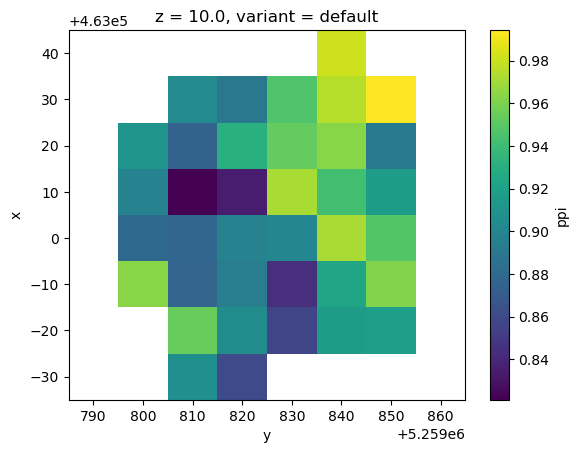

In [34]:
grid_10m_metrics.sel(variant='default')['ppi'].sel(z=10).plot()